# Supernova use case notebook

ALeRCE starter notebook for supernova science using the alerce client

In this notebook you will use the ALeRCE API to download some objects with probability greater than 0.7 of being supernova, get selected light curves and plot, as well as querying NED for galaxy crossmatches and displaying in Aladin.

### Load libraries

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from astropy.table import Table, Column

Import alerce api wrapper

In [2]:
#!pip install alerce
from alerce.api import AlerceAPI
client = AlerceAPI()

Astroquery https://astroquery.readthedocs.io/en/latest/

In [3]:
#!pip install astroquery
from astroquery.ned import Ned

Install pyaladin https://github.com/cds-astro/ipyaladin

In [4]:
# you may need to restart the notebook after running the following lines
#!pip install ipyaladin
#!jupyter nbextension enable --py widgetsnbextension
#!jupyter nbextension enable --py --sys-prefix ipyaladin

In [5]:
import ipyaladin as ipyal # see installation instructions here: https://github.com/cds-astro/ipyaladin

Show alerce.query help

# Classifier taxonomy and numeric mappings

There are two classifiers used in ALeRCE, an early classifier and a late classifier. Each one has its own numeric mappings for the different classes. You can use their string or integer names.

The early classifier uses as input the first detection stamps and contains the following classes:

    "agn"
    "sn"
    "vs"
    "asteroid"
    "bogus"
    
The late classifier uses the light curve information and contains the following classes:

    "sn ia"
    "sn ibc"
    "sn ii"
    "sn iin"
    "slsn"
    "eb/sd/d"
    "eb/c"
    "periodic/other"
    "cv/nova"
    "blazar"
    "agn i"
    "dsct"
    "ceph"
    "lpv"
    "rrl"
    "other"

In [7]:
help(client.query) # note the help classes are out of date...

Help on method query in module alerce.api:

query(params, format='votable') method of alerce.api.AlerceAPI instance
    Query the ALeRCE API to get matching objects into a pandas dataframe.
    
    Parameters
    ----------
    params : :py:class:`dict`
        Dictionary of parameters for the API. The current fields to query the db are the following:
    
        .. code-block:: json
    
            {
            total: number (if not set the total is counted and the query is slower),
            records_per_pages: number (default 20),
            page: number (default 1),
            sortBy: :py:class:`str` columnName (default nobs),
            query_parameters:{
               filters:{
                  //ZTF object id
                  oid: "ZTFXXXXXX",
                  //Number of detections
                  nobs: {
                      min: int
                      max: int
                  },
                  //Late Classifier (Random Forest)
                  classrf:

### Query top 100 SN candidates which exploded at least 70 days after ZTF's 1st light, that have a probability > 0.3 of being a SNe Ia, and which have between 10 and 50 detections

In [8]:
total = 100
records_per_page = 100
page = 1
sortBy = "pclassrf"
classrf = "sn ia"
pclassrf = 0.3
min_nobs = 10
max_nobs = 50
min_firstmjd = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd + 70

params = {
    #"total": total,
    "records_per_pages": records_per_page,
    "page": page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "pclassrf": pclassrf,
            "classrf": classrf,
            "nobs": {
                "min": min_nobs,
                "max": max_nobs
            },
            "dates": {
                "firstmjd": {
                    "min": min_firstmjd
                }
            }
        }
    }
}

In [9]:
SNe = client.query(params, format='pandas')
print(SNe.shape)
SNe.head()

(100, 43)


,catalogid,classearly,classrf,classxmatch,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,...,nobs,pclassearly,pclassrf,period,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19acbkczc,None,19,10,None,46.867361,18.3403,17.857700,18.270029,17.874170,58754.207940,...,19,0.999941,0.400,None,0.737337,0.456882,0.734734,0.484884,0.000030,0.000037
ZTF19abzzhgx,None,19,10,None,50.847326,19.965,19.876499,19.435148,19.475004,58747.463715,...,44,0.996774,0.400,None,0.717417,0.470939,0.634723,0.423922,0.000045,0.000049
ZTF19acjuitt,None,21,10,None,11.048889,18.5604,18.215040,18.640553,18.244732,58785.155382,...,20,0.737877,0.398,None,0.457042,0.322893,0.409333,0.355525,0.000025,0.000054
ZTF19abrogbl,None,19,10,None,55.911262,19.1737,18.860100,18.980923,18.749758,58719.463241,...,50,0.998825,0.396,None,0.90398,0.694199,0.879947,0.654772,0.000022,0.000026
ZTF19abujuex,None,19,10,None,54.854317,19.1822,19.629101,19.256208,19.372458,58724.438229,...,18,0.922142,0.394,None,0.607154,0.739758,0.614017,0.664285,0.000029,0.000022


### Create function to plot SN light curve

In [10]:
def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for fid in [1, 2]:
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            # note that detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf_corr, 
                yerr = SN_det[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:            
            # non detections index is mjd
            ax.scatter(SN_nondet[mask].index, SN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
                marker = 'v', label = "lim.mag. %s" % labels[fid])
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

### Create function to get data and plot SN light curve

In [16]:
def getSNdata(oid, doLC = False, dostamp = False, doNED = False):

    results = {}
    
    # query basic stats
    SN_stats = client.get_stats(oid, format='pandas')
    
    # query detections
    SN_det = client.get_detections(oid, format='pandas')
    results["LC_det"] = SN_det
        
    # query non detections
    SN_nondet = client.get_non_detections(oid, format='pandas')
    results["LC_nondet"] = SN_nondet
    
    if doLC:
        plotLC(oid, SN_det, SN_nondet)
        
    # find NED galaxies
    if doNED:
        co = coordinates.SkyCoord(ra=SNe.meanra[oid], dec=SNe.meandec[oid], unit=(u.deg, u.deg), frame='fk5')
        Ned_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(Ned_table)
        results["Ned_table"] = Ned_table
                
    if dostamp:
        client.plot_stamp(oid)
        

    # return data
    return results

### Get random SN

In [21]:
seloid = np.random.choice(SNe.index)
print(seloid)

ZTF18acqxwgl


### Do one SN with NED and Aladin

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J081020.79+521315.6,122.58674,52.22096,G,--,--,,23.3g,0.486,0,0,27,2,0,4,0
2,WISEA J081023.45+521241.6,122.59766,52.21157,*,--,--,,21.2g,0.507,0,0,23,3,0,4,0
3,SDSS J081024.02+521311.3,122.60012,52.21983,G,--,--,,20.9g,0.011,0,0,15,1,0,4,0
4,WISEA J081024.07+521336.3,122.60029,52.22677,IrS,--,--,,,0.412,0,0,12,1,0,0,0
5,SDSS J081024.24+521337.7,122.60102,52.22715,G,--,--,,21.8g,0.436,0,0,15,1,0,4,0
6,WISEA J081024.50+521259.6,122.60209,52.21656,IrS,--,--,,,0.217,0,0,12,1,0,0,0
7,WISEA J081024.43+521311.9,122.60225,52.21996,*,--,--,,19.8g,0.088,0,0,17,2,0,4,0
8,WISEA J081026.49+521302.4,122.61054,52.2174,*,--,--,,19.3g,0.42,0,0,23,3,0,4,0


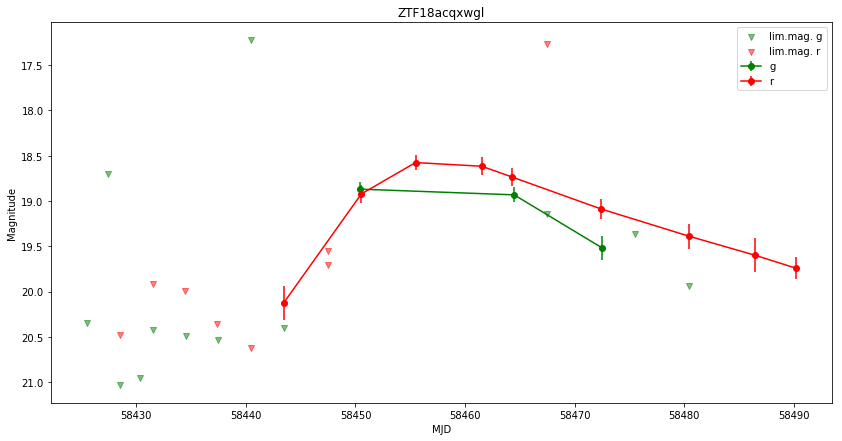

In [22]:
results = getSNdata(seloid, doLC=True, dostamp=True, doNED=True);
LC_det = results["LC_det"]
LC_nondet = results["LC_nondet"]
Ned_table = results["Ned_table"]

# Use Aladin to show nearby sources

In [23]:
info = widgets.HTML()

def process_objectHovered(data):
    
    output = '<font color="red">'
    # NED
    if data["data"]["cat_name"] == "Ned":
        output = "<h2>NED</h2>"
        sel_keys = ["Object Name", "Separation", "RA", "DEC", "Type", "Redshift", "Redshift Flag", "Magnitude and Filter"]
    for key in sel_keys:
        if key in data["data"].keys():
            output += "<p><font size='1'>%s: %s</p>" % (key, data["data"][key])
    info.value =  '%s' % output

In [24]:
aladin= ipyal.Aladin(target='%s %s' % (SNe.meanra[seloid], SNe.meandec[seloid]), 
                    fov=0.04, survey='P/PanSTARRS/DR1/color-z-zg-g',
                    reticle_size= 64,
                    layout=Layout(width='70%'))
box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', width='100%')
box = Box(children=[aladin, info], layout=box_layout)
display(box)
if Ned_table:
    Ned_table["cat_name"] = Column(["Ned"], name="cat_name")
    aladin.add_table(Ned_table)
aladin.add_listener('objectHovered', process_objectHovered)
print("Hover mouse to see information about catalog objects")

Box(children=(Aladin(fov=0.04, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', …

Hover mouse to see information about catalog objects


### Try more SNe

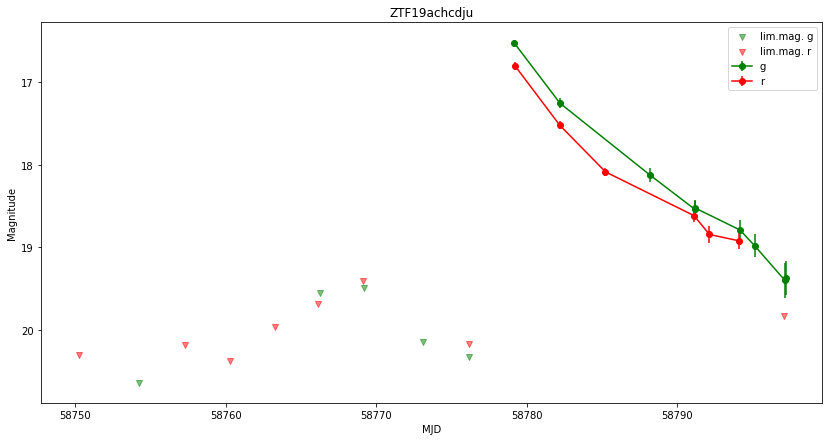

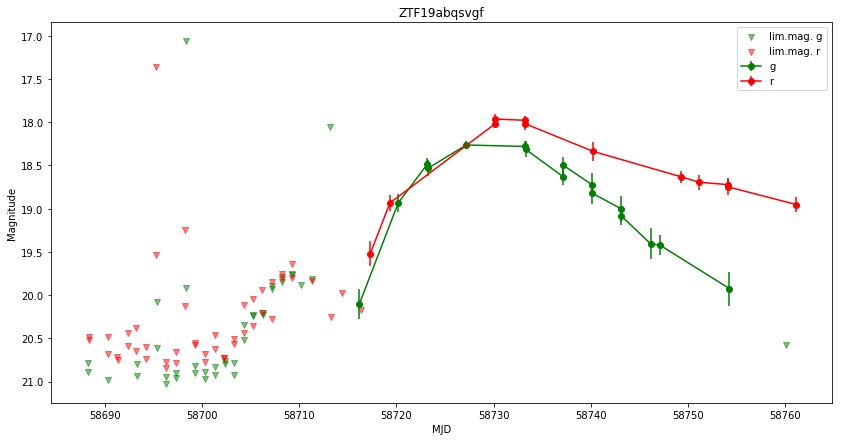

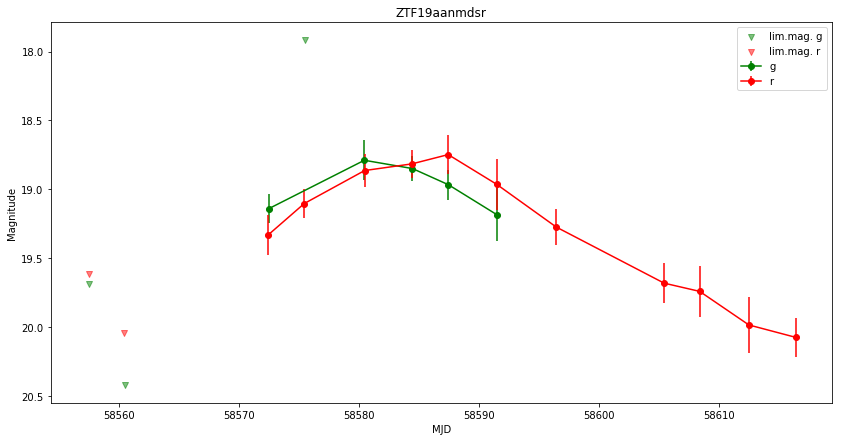

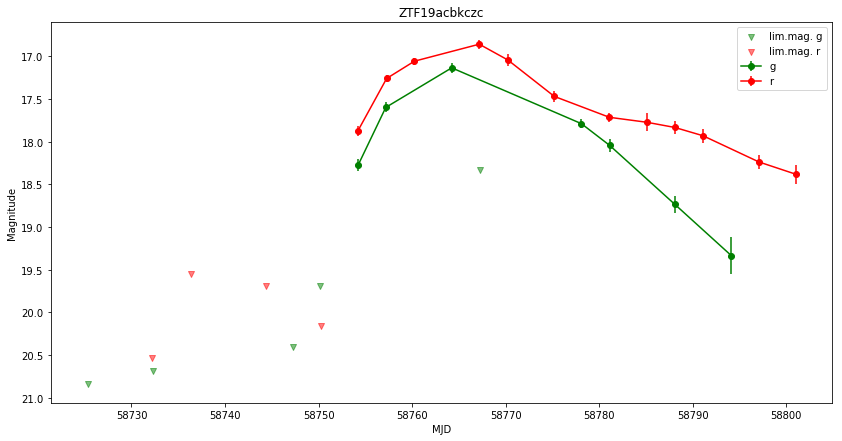

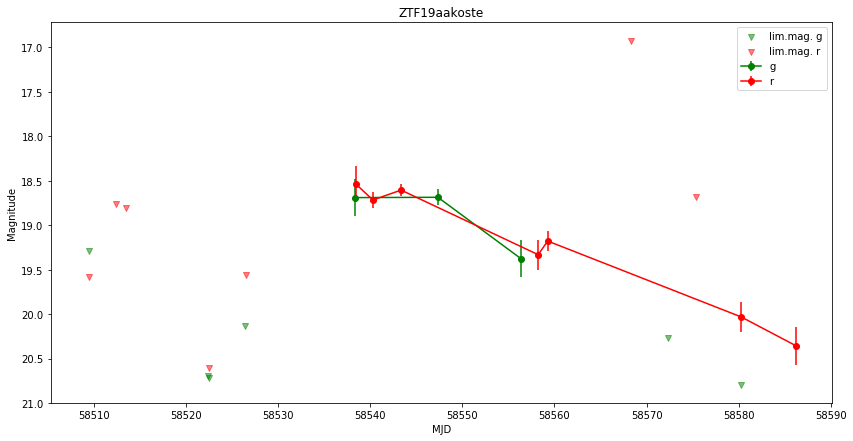

In [25]:
for oid in np.random.choice(SNe.index, size=5):
    getSNdata(oid, doLC = True, dostamp=True, doNED = False);